# Image Segmentation Part 2

To continue our journey into exploring Image Segmentation, we will delve deeper into two intriguing topics: Chromaticity Segmentation and Image Differencing. Building upon the foundation laid in the first part of our Image Segmentation series (If you haven't visited Part 1 visit here!: [Slice, Dice and Segment-ize](https://medium.com/@vjlglopez/slice-dice-and-segment-ize-3d178b41031d)),  we continue to unravel the true potential of images.

In this second installment, we dive into Chromaticity Segmentation and Image Differencing. In Chromaticity Segmentation, we explore Parametric Segmentation, which involves modeling statistical properties and using parameter estimation techniques for object identification based on chromaticity. Additionally, Non-Parametric Segmentation methods rely on adaptive algorithms without specific statistical assumptions. Moving on to Image Differencing, we discover how this technique detects changes by subtracting pixel values in multiple images, finding applications in surveillance, motion detection, and remote sensing. Expanding our knowledge in these areas equips us with valuable insights and tools for extracting meaningful information from images. Let's continue our exploration, building upon the foundation of our previous blog post, to unlock the next level of Image Segmentation expertise.

## Chromaticity Segmentation

Chromaticity Segmentation involves utilizing the RG Chromaticity space, which is a two-dimensional representation of color that disregards intensity information. Instead, it focuses on the proportion of the color channels' differences and maps them using the normalized RGB space. By operating in this chromaticity domain, Chromaticity Segmentation enables us to effectively analyze color relationships while disregarding intensity variations, leading to precise object identification and segmentation based on color characteristics.

The equations for RG chromaticity are as follows:

For the red component (r):

$$
r = \frac{R}{R + G + B}
$$

For the green component (g):

$$
g = \frac{G}{R + G + B}
$$

And the blue component (b) can be inferred as:

$$
b = 1 - r - g
$$

In these equations, R, G, and B represent the red, green, and blue color channels of a pixel in an image, respectively. The r, g, and b represent the RG chromaticity coordinates.

#### Parametric Segmentation

Parametric Segmentation techniques model the statistical properties of image pixels and estimate parameters to identify objects using chromaticity information.

We are again going to use our generated image from Microsoft Designer from  our first part of image segmentation with the prompt: 4 bean bags with colors red green blue yellow in a white room

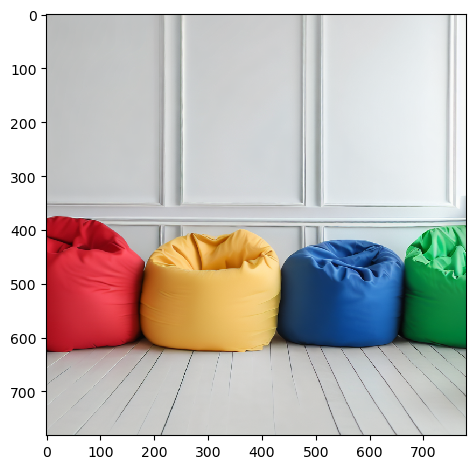

In [21]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import numpy as np
from skimage import color

bags = imread('bean_bags.PNG')[:,:,:-1]
imshow(bags);

To begin, we utilize the given equations to calculate the RG Chromaticity values. We can then determine the 2D histogram of the color values:

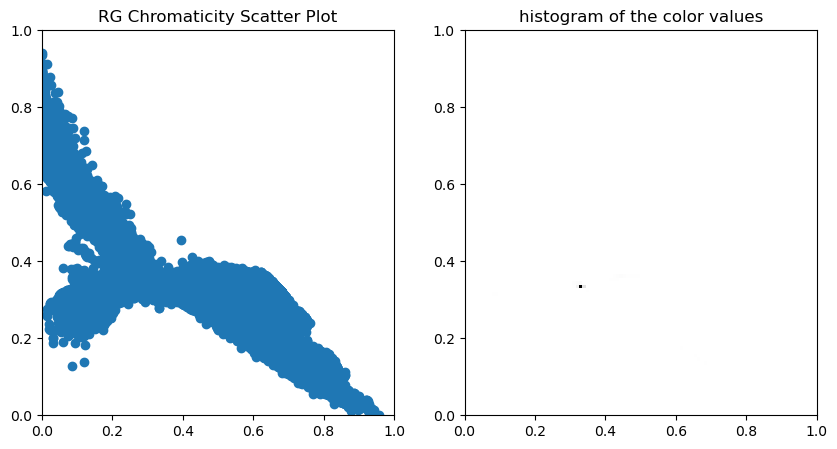

In [22]:
bags_R = bags[:,:,0]*1.0/bags.sum(axis=2)
bags_G = bags[:,:,1]*1.0/bags.sum(axis=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(bags_R.flatten(),bags_G.flatten())
ax[0].set_title('RG Chromaticity Scatter Plot')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)

ax[1].hist2d(bags_R.flatten(), bags_G.flatten(), bins=100,cmap='binary')
ax[1].set_title('histogram of the color values')
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1);

At this stage, we observe the color or group of colors that make up our image. To segment the image, we must select a reference patch and extract the RG Chromaticity values from that reference image. Let's focus on a red patch and get the red bean bag:

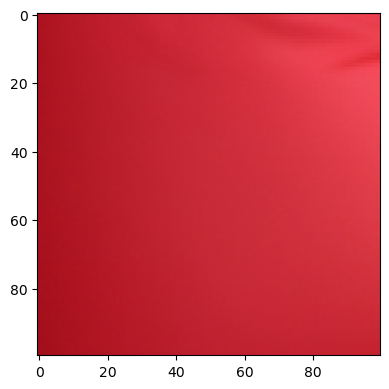

In [23]:
patch = bags[500:600,0:100,:]
plt.figure(figsize=(4,4))
imshow(patch);

To obtain the RG Chromaticity of the selected red patch, we apply the previously mentioned equations to calculate the corresponding values. By dividing the green channel value by the sum of the red, green, and blue channel values for each pixel in the patch, we can compute the RG Chromaticity coordinates.

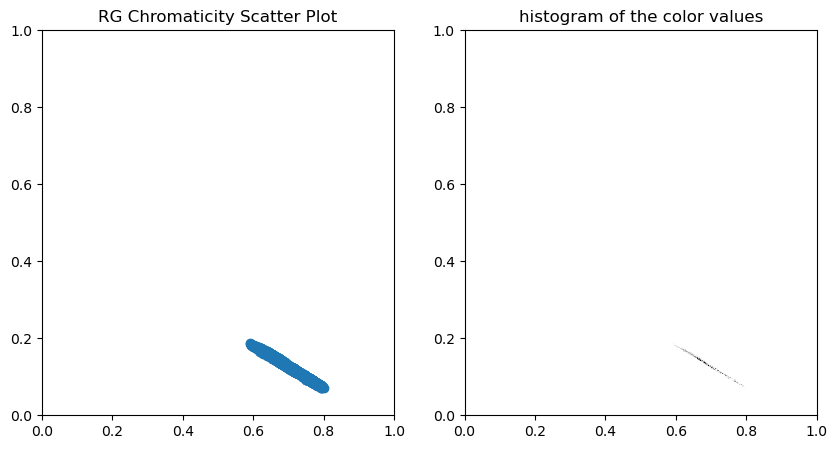

In [24]:
patch_R = patch[:,:,0]*1.0/patch.sum(axis=2)
patch_G = patch[:,:,1]*1.0/patch.sum(axis=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(patch_R.flatten(),patch_G.flatten())
ax[0].set_title('RG Chromaticity Scatter Plot')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)

ax[1].hist2d(patch_R.flatten(), patch_G.flatten(), bins=100,cmap='binary')
ax[1].set_title('histogram of the color values')
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1);

Our next step is to utilize the mask to fit a Gaussian probability distribution. This distribution plays a crucial role in determining the pixels that belong to the color we are interested in. To achieve this, we must calculate the Mean and Standard Deviation of our object of interest. These statistical measures provide essential parameters for the Gaussian distribution, guiding the classification of pixels and facilitating the segmentation process.

In [25]:
std_patch_R = np.std(patch_R.flatten())
mean_patch_R = np.mean(patch_R.flatten())

std_patch_G = np.std(patch_G.flatten())
mean_patch_G = np.mean(patch_G.flatten())

Here we define our Gaussian Function:

In [26]:
def gaussian(p,mean,std):
    """
    Compute the Gaussian probability density function (PDF) value at point p.

    Returns:
    float or numpy.ndarray: The computed PDF value(s) at point(s) p.
    """
    return np.exp(-(p-mean)**2/(2*std**2))*(1/(std*((2*np.pi)**0.5)))

Now applying it to our computed values:

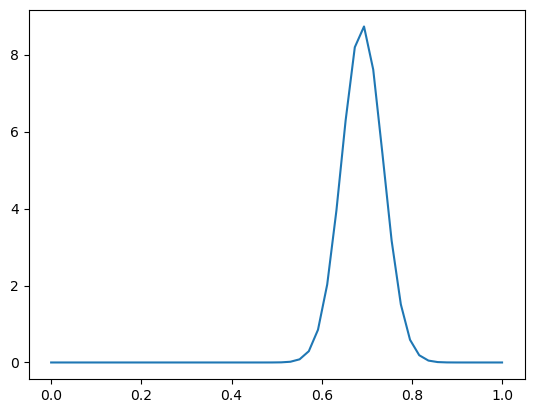

In [27]:
x = np.linspace(0,1)
y = gaussian(x,mean_patch_R,std_patch_R)
plt.plot(x,y);

To enhance our understanding, we can obtain a clearer visualization by projecting the obtained results onto our 2D chromaticity space.

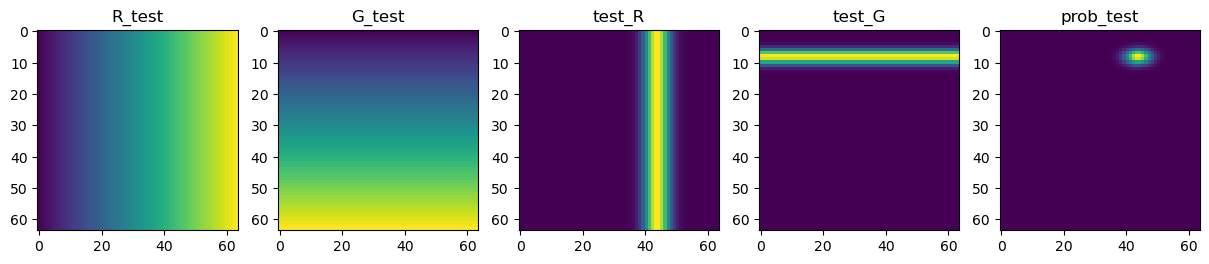

In [28]:
r_test = np.tile(np.linspace(0,1,64),(64,1))

g_test = r_test.transpose()

test_R = gaussian(r_test,mean_patch_R,std_patch_R)

test_G = gaussian(g_test,mean_patch_G,std_patch_G)

prob_test = test_R * test_G


fig, ax = plt.subplots(1, 5, figsize=(15, 5))
ax[0].imshow(r_test)
ax[0].set_title('R_test')
ax[1].imshow(g_test)
ax[1].set_title('G_test')
ax[2].imshow(test_R)
ax[2].set_title('test_R')
ax[3].imshow(test_G)
ax[3].set_title('test_G')
ax[4].imshow(prob_test)
ax[4].set_title('prob_test');

Using this distribution, we can determine the probability of a color being present in our image based on the R coordinate. By applying this probability as a mask, we can effectively segment and isolate the desired color in the image.

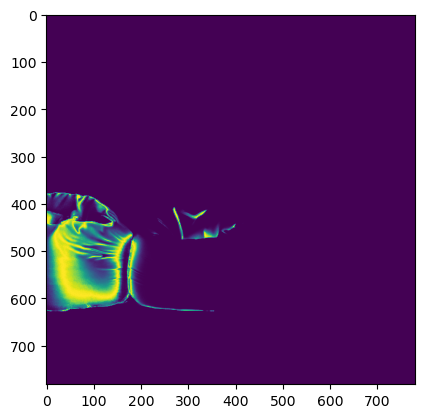

In [29]:
prob_R = gaussian(bags_R,mean_patch_R,std_patch_R)
plt.imshow(prob_R);

However, it's important to note that the existing approach only covers a specific range in the RG color space. To ensure a comprehensive coverage of the desired color range, we must also consider the G distribution. Incorporating the G distribution allows us to expand the mask and encompass a broader region in the RG color space, ensuring more accurate segmentation and isolation of the desired colors in the image.

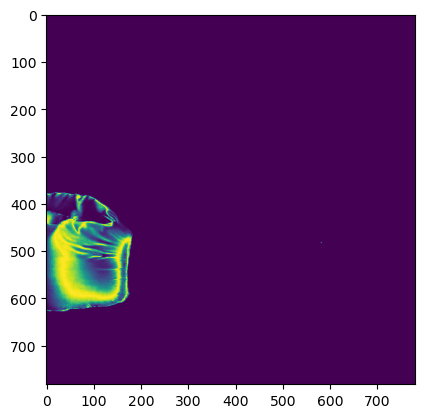

In [30]:
prob_G = gaussian(bags_G,mean_patch_G,std_patch_G)
plt.imshow(prob_G);

Since we are considering independent probabilities, we can easily combine the masks by multiplying them together.

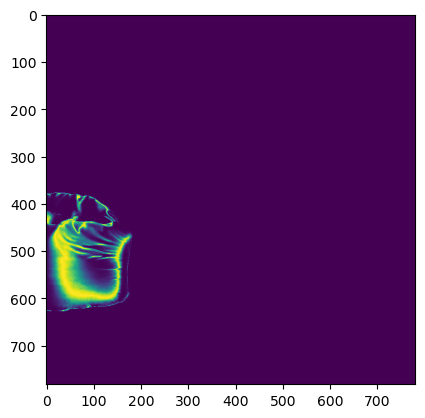

In [31]:
prob = prob_R * prob_G
plt.imshow(prob);

By performing the multiplication of the masks, we obtain the probability of the color being associated with our reference patch. This probability serves as the basis for generating a more refined mask through image segmentation.

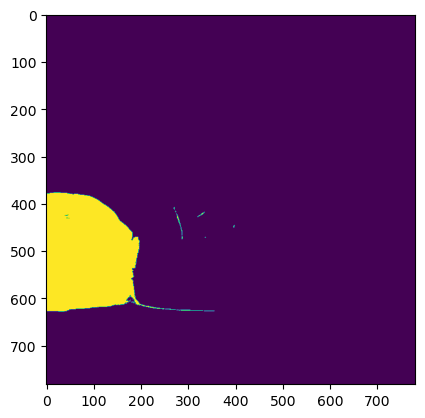

In [32]:
plt.imshow(prob>0.00000001);

Now let's look at the filtered red bean bag by applying our new threshold to the original image.

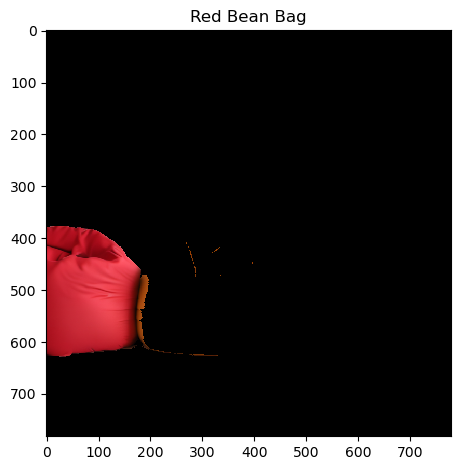

In [33]:
threshold = 0.00000001
binary_mask = (prob > threshold).astype(np.uint8)

masked_image = bags.copy()
masked_image[np.where(binary_mask == 0)] = 0
plt.title('Red Bean Bag')
imshow(masked_image);

#### Non-Parametric Segmentation

In situations where the region of interest cannot be accurately represented by a 2D Gaussian function, an alternative approach is to employ a non-parametric segmentation method. In this case, we utilize the 2D Histogram of the reference image and apply histogram backprojection to create a mask for the original image. This involves computing the histogram of the reference patch and then mapping it onto the original image, effectively masking out regions that do not match the histogram of the reference patch.

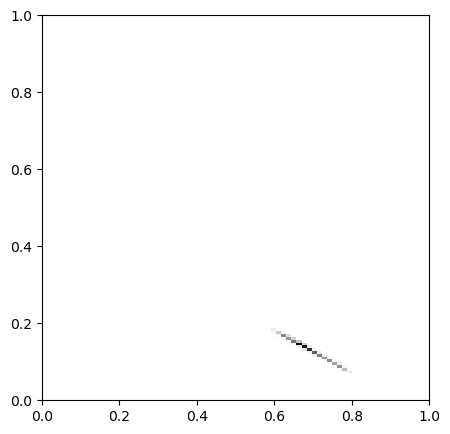

In [34]:
plt.figure(figsize=(5,5))
plt.hist2d(patch_R.flatten(), patch_G.flatten(), bins=16,cmap='binary')
plt.xlim(0,1)
plt.ylim(0,1);

To accomplish this, we employ histogram back-projection, where each pixel location is assigned a value corresponding to its histogram value in the chromaticity space. This technique involves creating a histogram of the reference patch in the chromaticity space and then utilizing this histogram as a reference to map pixel values in the original image. By assigning pixel values based on their chromaticity histogram values, we effectively create a mask that highlights regions in the original image that exhibit similar chromaticity characteristics to the reference patch.

Non-parametric segmentation proves particularly advantageous when it comes to segmenting images with multiple colors. Let's implement it to our bean bags sample image.

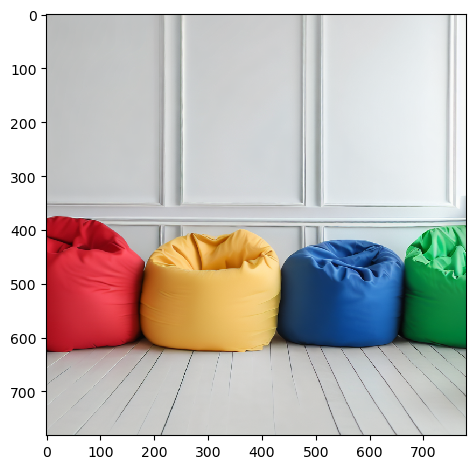

In [35]:
bags_np = imread('bean_bags.PNG')[:,:,:-1]
imshow(bags_np);

Let's create different patches from our bean bag image and create a segmentation model by implementing the backprojection algorithm.

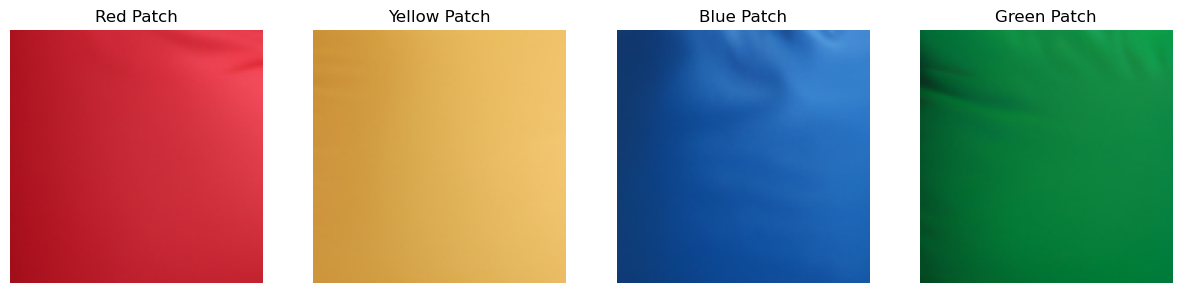

In [36]:
patch_red = bags[500:600, 0:100, :]
patch_yellow = bags[500:600, 250:350, :]
patch_blue = bags[500:600, 525:625, :]
patch_green = bags[500:600, 680:780, :]

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(patch_red)
ax[0].set_title('Red Patch')
ax[0].axis('off')
ax[1].imshow(patch_yellow)
ax[1].set_title('Yellow Patch')
ax[1].axis('off')
ax[2].imshow(patch_blue)
ax[2].set_title('Blue Patch')
ax[2].axis('off')
ax[3].imshow(patch_green)
ax[3].set_title('Green Patch')
ax[3].axis('off');

In [37]:
class BackprojectionSegmentationModel:
    def __init__(self):
        """
        Initializes the BackprojectionSegmentationModel.
        """
        self.reference_hist = None

    def train(self, reference_image):
        """
        Trains the segmentation model using the patch image.
        """
        reference_hsv = color.rgb2hsv(reference_image)
        hist, _, _ = (
            np.histogram2d(
                reference_hsv[:,:,0].flatten(),
                reference_hsv[:,:,1].flatten(),
                bins=[50, 256],
                range=[[0, 1], [0, 1]])
        )
        self.reference_hist = hist / np.max(hist)
    
    def segment(self, target_image, threshold=0.5):
        """
        Performs segmentation on a target image using the trained model.
        
        Returns:
            ndarray: The segmented image containing only
            the pixels that belong to the target object.
        """
        target_hsv = color.rgb2hsv(target_image)

        h_indices = (target_hsv[:, :, 0] * 50).astype(int)
        s_indices = (target_hsv[:, :, 1] * 255).astype(int)
        prob = self.reference_hist[h_indices, s_indices]

        prob = prob / np.max(prob)

        mask = prob > threshold

        segmented_image = target_image.copy()
        segmented_image[~mask] = 0

        return segmented_image

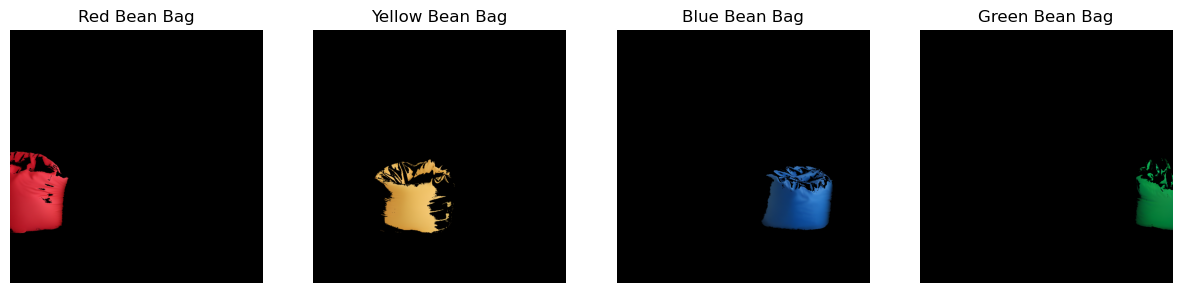

In [38]:
def get_bag(image, patch, thresh):
    """
    Segments a specific bag from an image using
    the BackprojectionSegmentationModel.

    Returns:
        ndarray: The segmented image containing only
        the pixels belonging to the bag.

    """
    model = BackprojectionSegmentationModel()
    model.train(patch)
    segmented_image = model.segment(image, threshold=thresh)
    return segmented_image

red_bean_bag = get_bag(bags_np, patch_red, 0.00000001)
yellow_bean_bag = get_bag(bags_np, patch_yellow, 0.00000001)
blue_bean_bag = get_bag(bags_np, patch_blue, 0.00000001)
green_bean_bag = get_bag(bags_np, patch_green, 0.00000001)


fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(red_bean_bag)
ax[0].set_title('Red Bean Bag')
ax[0].axis('off')
ax[1].imshow(yellow_bean_bag)
ax[1].set_title('Yellow Bean Bag')
ax[1].axis('off')
ax[2].imshow(blue_bean_bag)
ax[2].set_title('Blue Bean Bag')
ax[2].axis('off')
ax[3].imshow(green_bean_bag)
ax[3].set_title('Green Bean Bag')
ax[3].axis('off');

## Image Differencing

Image differencing is a powerful technique that allows us to detect changes or movement in videos or images. Rather than segmenting based on color for regions of interest, we can utilize image differencing to identify objects of interest by analyzing the differences between two images. By subtracting corresponding pixel values, we can highlight areas where significant changes have occurred, indicating the presence of objects or motion. This approach provides an alternative way to locate and track objects without relying solely on color-based segmentation. By examining the difference between images, we can extract meaningful information about object movement and changes, enabling a wide range of applications such as surveillance, video analysis, and motion detection.

Let's play a game! Our sample image is from [FreePik](https://www.freepik.com/free-vector/find-10-differences-pack_12143315.htm#query=spot%20difference&position=1&from_view=keyword&track=ais#position=1&query=spot%20difference). SPOT THE DIFFERENCE and see how many you can get!

SPOT THE DIFFERENCE!


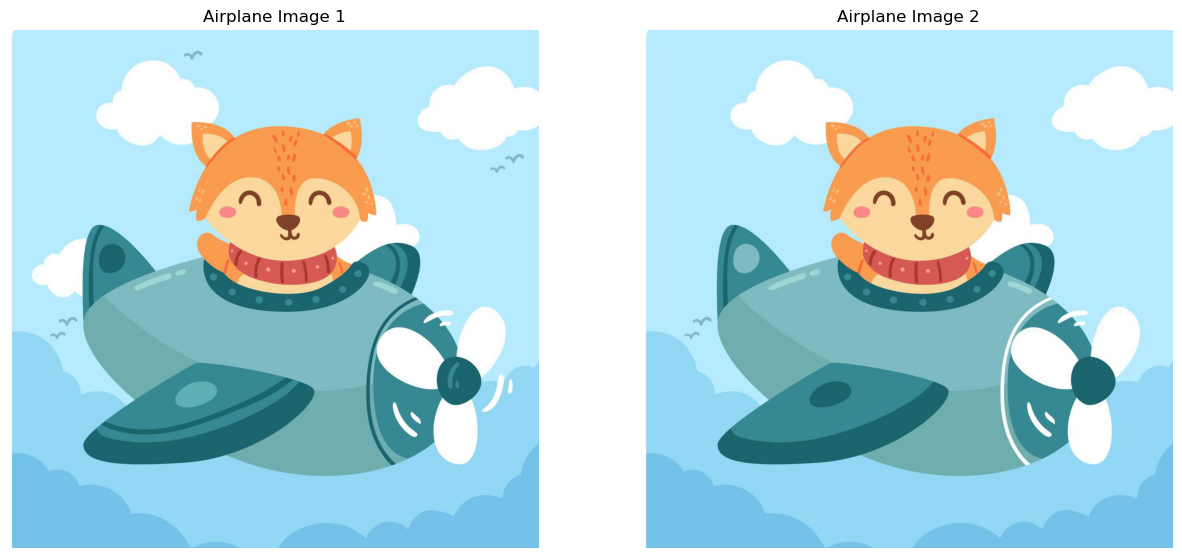

In [75]:
airplane_1 = imread('airplane_1.jpg')
airplane_2 = imread('airplane_2.jpg')

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(airplane_1)
ax[0].axis('off')
ax[0].set_title('Airplane Image 1')
ax[1].imshow(airplane_2)
ax[1].axis('off')
ax[1].set_title('Airplane Image 2');

To perform image differencing, we have to first convert both images to grayscale.

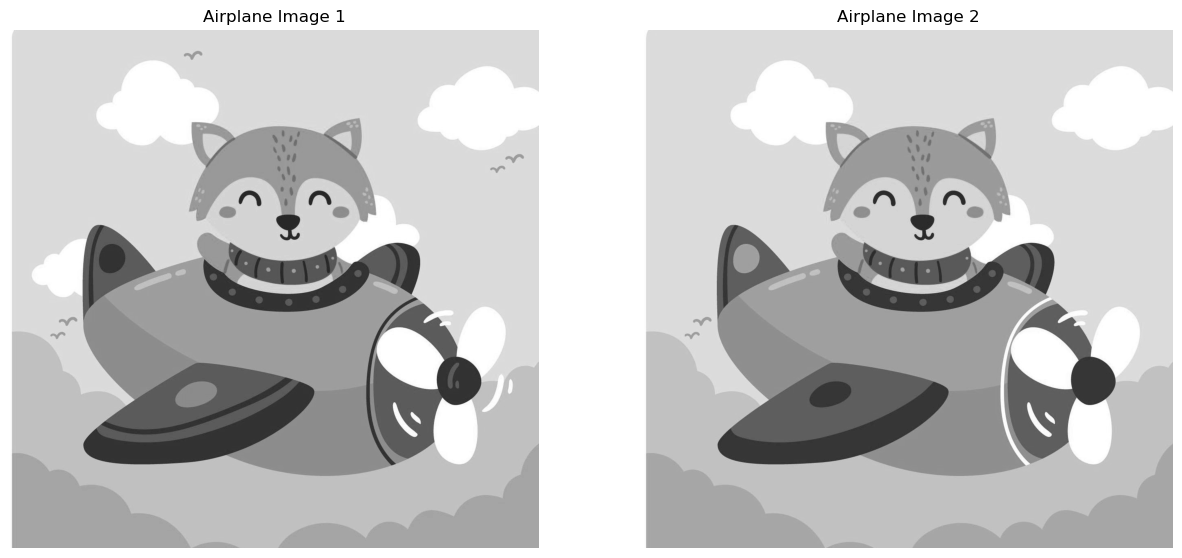

In [82]:
from skimage.color import rgb2gray

airplane_1_gray = rgb2gray(airplane_1)
airplane_2_gray = rgb2gray(airplane_2)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(airplane_1_gray, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Airplane Image 1')
ax[1].imshow(airplane_2_gray, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Airplane Image 2');

We now perform image differencing and see if we can get all mismatches from our sample images.

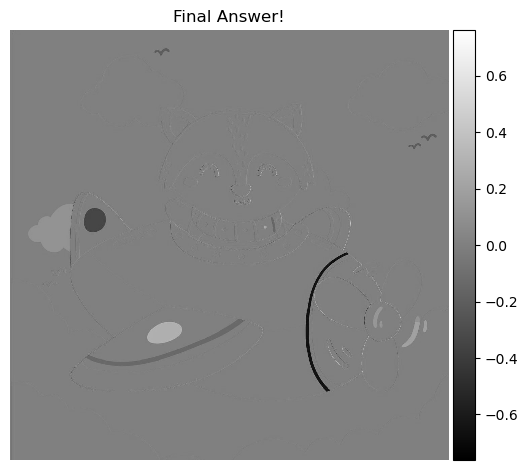

In [81]:
diff = airplane_1_gray - airplane_2_gray
plt.title('Final Answer!')
plt.axis('off')
imshow(diff, cmap='gray');

How many did you get? The final answer is 10 differences! I hope you enjoyed our little game.

In conclusion, Chromaticity Segmentation and Image Differencing offer powerful techniques for extracting valuable information from images. By operating in the chromaticity domain, Chromaticity Segmentation allows us to analyze color relationships and precisely identify objects based on their color characteristics. Whether using parametric or non-parametric approaches, these methods enable accurate object identification and segmentation. On the other hand, Image Differencing provides a means to detect changes and movement in images or videos. By subtracting pixel values, it highlights areas of dissimilarity, aiding in motion detection, object tracking, and change monitoring. Both techniques have a wide range of applications, from surveillance and remote sensing to computer vision tasks. By harnessing the potential of Chromaticity Segmentation and Image Differencing, we can uncover deeper insights and unlock new possibilities in the realm of image segmentation. Stay tuned for future explorations into the exciting field of image analysis and segmentation!